In [1]:
import pandas as pd
import re
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.charsets import AR_LETTERS_CHARSET
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator

In [5]:
#load_the_data
data = pd.read_csv("C:\\Users\\Dalia\\Downloads\\cluster_test.csv")
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7
0,اسم الكتاب,الكاتب,قسم الكتاب,عدد الصفحات,دار النشر,حجم الكتاب,تلخيص الكتاب
1,كتاب لغز القبر الملكي,\nالكاتب محمود سالم\n,روايات بوليسية,52 صفحة,مؤسسة هنداوي,2 ميغابايت,هذا الاكتشاف الأثري على وشك اكتشافات أثرية أكث...
2,كتاب لغز الكوخ المحترق,\nالكاتب محمود سالم\n,روايات بوليسية,56 صفحة,مؤسسة هنداوي,2 ميغابايت,بدأت المغامرة المثيرة في إحدى ليالي سبتمبر في ...
3,كتاب لغز اللص الشبح,\nالكاتب محمود سالم\n,روايات بوليسية,48 صفحة,مؤسسة هنداوي,2 ميغابايت,أمضى تختخ بقية المساء يفكر في اللغز في وكلما ح...
4,كتاب لغز المدينة العائمة,\nالكاتب محمود سالم\n,روايات بوليسية,54 صفحة,مؤسسة هنداوي,2 ميغابايت,قد وقع في عشرات المآزق و وخاض أكثر من صراع واح...


In [7]:
#initializing stop words array
stopwords = []
with open('C:\\Users\\Dalia\\Downloads\\Graduation Project/Data/arabic-stop-words-master/list.txt', encoding='utf8') as file:
    for line in file:
        stopwords.append(line.strip())


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Column1  36 non-null     object
 1   Column2  36 non-null     object
 2   Column3  36 non-null     object
 3   Column4  36 non-null     object
 4   Column5  36 non-null     object
 5   Column6  36 non-null     object
 6   Column7  36 non-null     object
dtypes: object(7)
memory usage: 2.1+ KB


## 1)Cleaning our data:

    remove urls
    Mentions
    Emotions
    Symbols
    Diacritical marks
    Shapes
    Unwanted Punctuation (basicly anything that is not an arabic word or a number).

In [9]:
def clean_text(text):
    sentence_ar_dediac = dediac_ar(text) #dediacritization using camel tools
    sentence_ar_dediac = re.sub(r"\S*https?:\S*|@\S+", "", sentence_ar_dediac) #remove URLs and mentions even if they are in paranthesis or brackets
    no_punc = ""
    for char in sentence_ar_dediac:
        if char in (list(AR_LETTERS_CHARSET)+[" "]): #removing any thing that is not an arabic letter
            no_punc = no_punc + char
    return no_punc

## 2) Normalizing our data
    Orthographic Normalization
    Unicode Normalization

In [10]:
def normalize_text(text):
    cleaned_text = normalize_alef_maksura_ar(text)
    cleaned_text = normalize_alef_ar(cleaned_text)
    cleaned_text = normalize_teh_marbuta_ar(cleaned_text)
    cleaned_text = normalize_unicode(cleaned_text)
    
    return cleaned_text

## 3)Stopwords and tokenization

In [11]:
def enrichement(text, stopwords=stopwords):
    tokens = simple_word_tokenize(text)
    tokenized = []
    for token in tokens:
        if token not in stopwords:
            tokenized.append(token)
    mle = MLEDisambiguator.pretrained()      
    disambig = mle.disambiguate(tokenized)
    lemmas = [d.analyses[0].analysis['lex'] for d in disambig]
    return lemmas

In [69]:
def preprocess_text(text, clean_text=clean_text, normalize_text=normalize_text, enrichement=enrichement):
    '''
    Inputs:
    text: string in which it will preprocess.
    
    Outputs:
    cleaned_text: the string after it was processed.
    '''
    
    #let's first start with cleaning 
    cleaned = clean_text(text)
                
    # now, for the normalization part
    normalized = normalize_text(cleaned)
    
    #enrichement
    enriched = enrichement(normalized)
    #return normalized
    return enriched

In [70]:
def preprocess_data(data, preprocess_text=preprocess_text):
    '''
    Inputs:
    data: is the dataframe we want to apply our function on
    
    Outputs:
    data: the dataframe after applying the cleaning and normalization on each cell.
    
    '''
    for row in range(data.shape[0]):
        for column in range(data.shape[1]):
            for_cleaning = str(data.iloc[row][column])
            data.iloc[row][column] = preprocess_text(for_cleaning)
    return data


In [71]:
data=preprocess_data(data)
data.head()


,Column1,Column2,Column3,Column4,Column5,Column6,Column7
0,"[ٱِسْم, كِتاب]",[كاتِب],"[قِسْم, كِتاب]",[صَفْحَة],"[دار, نَشْر]","[حَجْم, كِتاب]","[تَلْخِيص, كِتاب]"
1,"[كِتاب, لُغْز, قَبْر, مَلَكِيّ]","[كاتِب, مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[ٱِكْتِشاف, أَثَرِيّ, وَشْك, ٱِكْتِشاف, أَثَر,..."
2,"[كِتاب, لُغْز, كُوخ, المحترق]","[كاتِب, مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[بَدَأ, مُغامَرَة, مُثِير, أَحَد, لَيْلَة, ساع..."
3,"[كِتاب, لُغْز, لِصّ, شَبَح]","[كاتِب, مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[أَمْضَى, تَخْتَخ, بَقِي, مَساء, فَكَّر, لُغْز..."
4,"[كِتاب, لُغْز, مَدِينَة, عائِم]","[كاتِب, مَحْمُود, سالِم]","[رِوايَة, بُولِيسِيّ]",[صَفْحَة],"[مُؤَسِّس, هِنْداوِيّ]",[مِيغابايت],"[وَقَع, عَشَرات, مَأْزِق, خاض, صِراع, شارَك, ص..."


In [72]:
#set of unique words
wordset=[]
for row in range(data.shape[0]):
    for column in range(data.shape[1]):
        for token in data.iloc[row][column]:
            if token not in wordset:
                wordset.append(token)

In [73]:
#function returns the dictionary of the row
def row_dictionary(row,wordset):
    for column in range(data.shape[1]):
        word_dict=dict.fromkeys(wordset, 0)
        for token in data.iloc[row][column]:
            word_dict[token] += 1
    return word_dict

In [74]:
#function takes row number and returns tokens in the whole row
def row_tokens(row):
    tokens=[]
    for column in range(data.shape[1]):
        for token in data.iloc[row][column]:
            tokens.append(token)
    return tokens    

In [75]:
#function make dictionary array by passing on every row
def Dictionary(data,wordset):
    dict=[]
    for row in range(0,data.shape[0]-1):
        dict.append(row_dictionary(row,wordset))
    return dict

In [76]:
def compute_tf(word_dict, l):
    tf = {}
    sum_nk = len(l)
    for word, count in word_dict.items():
        tf[word] = count/sum_nk
    return tf

In [77]:
import numpy as np
def compute_idf(strings_list):
    import math
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1
    
    for word, v in idf.items():
        if (v!=0):
            idf[word] = np.log(n / float(v))
    return idf

In [78]:
def compute_tf_idf(tf, idf):
    tf_idf = dict.fromkeys(tf.keys(), 0)
    for word, v in tf.items():
        tf_idf[word] = v * idf[word]
    return tf_idf


In [79]:
dictionary=Dictionary(data,wordset)#retrieve the dictionary for the whole file
Tf=[]
Idf=(compute_idf(dictionary))
TfIdf=[]
for i in range(0,data.shape[0]-1):
    Tf.append(compute_tf(dictionary[i],row_tokens(i)))
    TfIdf.append(compute_tf_idf(Tf[i],Idf))

    

In [80]:
print(TfIdf)

[{'ٱِسْم': 0.0, 'كِتاب': 0.0, 'كاتِب': 0.0, 'قِسْم': 0.0, 'صَفْحَة': 0.0, 'دار': 0.0, 'نَشْر': 0.0, 'حَجْم': 0.0, 'تَلْخِيص': 0.29627900512411776, 'لُغْز': 0.0, 'قَبْر': 0.0, 'مَلَكِيّ': 0.0, 'مَحْمُود': 0.0, 'سالِم': 0.0, 'رِوايَة': 0.0, 'بُولِيسِيّ': 0.0, 'مُؤَسِّس': 0.0, 'هِنْداوِيّ': 0.0, 'مِيغابايت': 0.0, 'ٱِكْتِشاف': 0.0, 'أَثَرِيّ': 0.0, 'وَشْك': 0.0, 'أَثَر': 0.0, 'أَهَمِّيَّة': 0.0, 'فَتْح': 0.0, 'كان': 0.0, 'مَعْرُوف': 0.0, 'تارِيخ': 0.0, 'مِصْر': 0.0, 'فِرْعَوْنِيّ': 0.0, 'إِبّان': 0.0, 'حُكْم': 0.0, 'أَمْنِيّ': 0.0, 'ثالِث': 0.0, 'فِرْعَوْن': 0.0, 'حِوال': 0.0, 'أَلْف': 0.0, 'سنهمن': 0.0, 'وَرَق': 0.0, 'صَغِير': 0.0, 'كَتَب': 0.0, 'عِبارَة': 0.0, 'أَرْبَع': 0.0, 'سَنَة': 0.0, 'مُلْقَى': 0.0, 'أَرْض': 0.0, 'مَنْزِل': 0.0, 'عالَم': 0.0, 'مِصْرِيّ': 0.0, 'دُكْتُور': 0.0, 'رِياض': 0.0, 'مُعادِي': 0.0, 'كَبِير': 0.0, 'فَيُّوم': 0.0, 'تَعَلَّق': 0.0, 'مَقْبَر': 0.0, 'مِلْكِيَّة': 0.0, 'امنمحات': 0.0, 'ثَلاث': 0.0, 'مَلِك': 0.0, 'أُسْرَة': 0.0, 'ثانِي': 0.0, 'قَدِيم': 0.0, 'نَجَح'

In [86]:
from sklearn.cluster import KMeans
k=7
data1 = pd.read_csv("C:\\Users\\Dalia\\Downloads\\cluster_test.csv")
X = data1[["Column3","Column7"]]
print(X)
model=KMeans(n_clusters=k,init='k-means++',max_iter=100,n_init=1)
model.fit(X)

                           Column3  \
0                       قسم الكتاب   
1                   روايات بوليسية   
2                   روايات بوليسية   
3                   روايات بوليسية   
4                   روايات بوليسية   
5                   روايات بوليسية   
6                   روايات بوليسية   
7                   روايات بوليسية   
8     كتب الأدب العربي  كتب متنوعة   
9      كتب تطوير الذات  كتب متنوعة   
10                كتب الأدب العربي   
11                     كتب اسلامية   
12                كتب الأدب العربي   
13              كتب الأدب العربي     
14                     كتب اسلامية   
15           كتب الكاتب هارون يحيى   
16                     كتب اسلامية   
17                     كتب اسلامية   
18                  روايات بوليسية   
19                  روايات بوليسية   
20                  روايات بوليسية   
21                    كتب اسلامية    
22                كتب الأدب العربي   
23                 الثقافة العامة    
24                     كتب اسلامية   
25          

ValueError: could not convert string to float: 'قسم الكتاب'

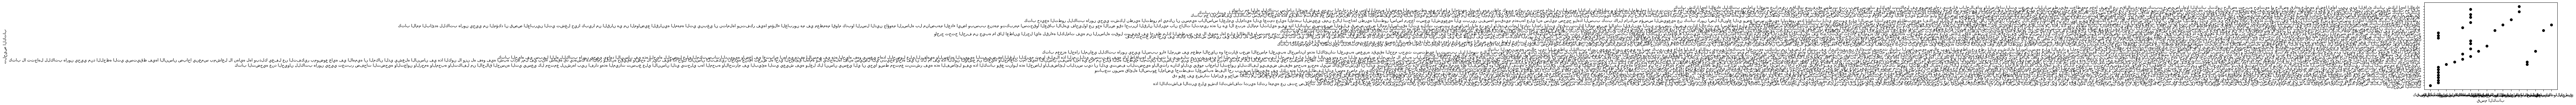

In [61]:
"""""
import matplotlib.pyplot as plt
X = data[["Column3","Column7"]]
#Visualise data points
plt.scatter(X["Column3"],X["Column7"],c='black')
plt.xlabel('قسم الكتاب')
plt.ylabel('تلخيص الكتاب')
plt.show()
"""""

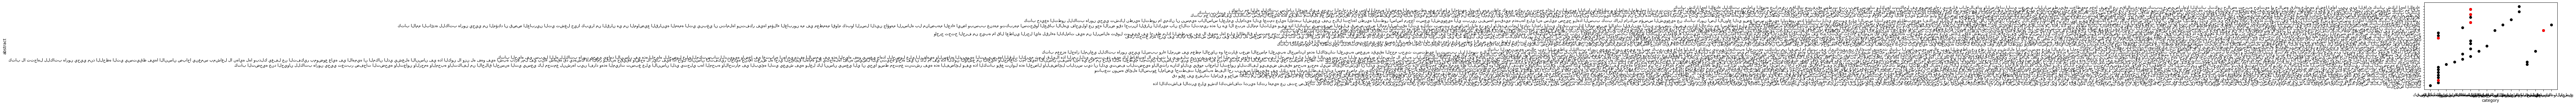

In [62]:
"""""
#number of clusters
K=6

# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.scatter(X["Column3"],X["Column7"],c='black')
plt.scatter(Centroids["Column3"],Centroids["Column7"],c='red')
plt.xlabel('category')
plt.ylabel('abstract')
plt.show()
"""""

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=6, n_init=1)

In [67]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms

['column1', 'column2', 'column3', 'column4', 'column5', 'column6', 'column7']

In [68]:
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print('------------------------------------------')

print("\n")

Cluster 0:
 column6
 column5
 column7
 column4
 column3
 column2
 column1
------------------------------------------
Cluster 1:
 column4
 column7
 column6
 column5
 column3
 column2
 column1
------------------------------------------
Cluster 2:
 column1
 column7
 column6
 column5
 column4
 column3
 column2
------------------------------------------
Cluster 3:
 column3
 column7
 column6
 column5
 column4
 column2
 column1
------------------------------------------
Cluster 4:
 column2
 column7
 column6
 column5
 column4
 column3
 column1
------------------------------------------
Cluster 5:
 column7
 column6
 column5
 column4
 column3
 column2
 column1
------------------------------------------




In [44]:
Y = vectorizer.transform(["كتاب الله"])
prediction = model.predict(Y)
print(prediction)

[2]


In [35]:
#elbow method
from sklearn.cluster import KMeans
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

#inertia here is referring to total sum of squares (or inertia) I of a cluster

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


ValueError: could not convert string to float: 'قسم الكتاب'